<a href="https://colab.research.google.com/github/accarter/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

## Data Wrangling

### Filters

In [ ]:
import numpy as np


def population_filter(se):
  '''
  Replaces rows with populations of 1 or fewer with np.nan.
  Replaces rows with outliers with np.nan.
  '''
  return pd.Series(np.where((se <= 1) | (se == np.nan), np.nan, se))


def remove_outliers(se):
  '''
  Remove outer 1% of values (outliers).
  '''
  se = se.dropna()
  return pd.Series(np.where((se >= np.percentile(se, 0.5)) &
                            (se <= np.percentile(se, 99.5)), se, np.nan))


def amount_tsh_filter(se):
  '''
  Replaces total static head values less than 0 with np.nan.
  '''
  return pd.Series(np.where((se <= 0), np.nan, se))


def gps_height_filter(se):
  '''
  Replaces gps height values of 0 or less with np.nan.
  '''
  return pd.Series(np.where(se <= 1, np.nan, se))


def construction_year_filter(se):
  '''
  Replaces construction years of 0 with np.nan.
  '''
  return pd.Series(np.where(se == 0, np.nan, se))


def num_private_filter(se):
  '''
  Replaces num private values of 0 or less with np.nan.
  '''
  return pd.Series(np.where(se <= 0, np.nan, se))


def axis_filter(se):
  '''
  Replaces latitude values of -2e-08 with np.nan.
  Replaces longitude vales of 0.0 with np.nan.
  '''
  null_lat = se.value_counts().index[0]
  return pd.Series(np.where(se == null_lat, np.nan, se))


def clean(filter):
  '''
  Decorator function for casting pd.Series as type float
  and removing any outliers after applying the specified filter.
  '''
  def wrapper(se):
    return remove_outliers(filter(se.astype(float)))
  return wrapper

### Replacements for Null Values

Configuration for filters/metrics used to identify, replace, and impute missing values

In [ ]:
numeric_features = ['population', 'amount_tsh', 'gps_height', 
                    'latitude', 'longitude', 'num_private']

measurements = ['mean', 'median', 'median', 'mean', 'mean', 'mode']

filters = [population_filter, amount_tsh_filter, gps_height_filter, 
           axis_filter, axis_filter, num_private_filter]

replacement_config = dict(zip(numeric_features, zip(measurements, filters)))

measurement_funcs = {
    'mean': lambda se: se.mean(),
    'mode': lambda se: se.mode()[0],
    'median': lambda se: se.median()
}

def find_replacement(df, feature):
  measurement, filter = replacement_config[feature]
  return measurement_funcs[measurement](clean(filter)(df[feature]))

# combine DataFrames for generating replacement values
tanzania = pd.concat([train.copy(), test.copy()])
replacements = {feature: find_replacement(tanzania, feature) for feature in numeric_features}
replacements

{'amount_tsh': 250.0,
 'gps_height': 1192.0,
 'latitude': -5.879993833884067,
 'longitude': 35.15198731008472,
 'num_private': 1.0,
 'population': 319.22367730422}

Impute Latitude, Longitude, GPS Height, and Population by Region/Basin

In [ ]:
def get_means_by_region(X, features=['latitude', 'longitude', 'gps_height', 'population']):
  X = X.copy()
  grouped_by_region = X.groupby(['district_code', 'basin'])
  regional_features = {}
  for feature in features:
    regional_features[feature] = {}
    X[feature] = replacement_config[feature][1](X[feature])
    means_by_region = grouped_by_region[feature].mean()
    regional_means = {}
    for (code, basin), avg in zip(means_by_region.index, means_by_region.values):
      regional_means[f'{code}-{basin}'] = avg
    regional_features[feature] = regional_means
  return regional_features

def replace_by_location(X, features=['latitude', 'longitude', 'gps_height', 'population']):
  X = X.copy()
  for feature in features:
    X[feature] = replacement_config[feature][1](X[feature])
    for k, avg in regional_features[feature].items():
      code, basin = k.split('-')
      if np.isnan(avg):
        avg = district_features[feature][code]
      code = float(code)
      mask = ((X['district_code'] == code) & 
              (X['basin'] == basin) & 
              (X.apply(lambda x: np.isnan(x[feature]), axis=1)))
      X[feature] = pd.Series(np.where(mask, avg, X[feature]))
  return X

def get_means_by_district(X, features=['latitude', 'longitude', 'gps_height', 'population']):
  X = X.copy()
  grouped_by_district = X.groupby(['district_code'])
  district_features = {}
  for feature in features:
    district_features[feature] = {}
    X[feature] = replacement_config[feature][1](X[feature])
    means_by_district = grouped_by_district[feature].mean()
    district_means = {}
    for code, avg in zip(means_by_district.index, means_by_district.values):
      if np.isnan(avg):
        avg = replacements[feature]
      district_means[f'{code}'] = avg
    district_features[feature] = district_means
  return district_features

tanzania = pd.concat([train, test])
regional_features = get_means_by_region(tanzania)
district_features = get_means_by_district(tanzania)

### Feature Engineering

Distance from Functional Epicenter for Basin/District

In [ ]:
from geopy.distance import great_circle

In [ ]:
# determine the average latitude and longitude for all functional water pumps;
# used to calculate the distance of a water pump from this point

functional_epicenters = {}

region_groups = train.groupby(['district_code', 'basin']).mean().index
for code, basin in region_groups:
  mask = ((train['district_code'] == code) & 
          (train['basin'] == basin) & 
          (train['status_group'] == 'functional'))
  epicenter = tuple(train[mask][axis].mean() for axis in ('latitude', 'longitude'))
  functional_epicenters[f'{code}-{basin}'] = epicenter


def mean_district_epicenter(district):
  lat, lon, n = 0, 0, 0
  for k, coord in functional_epicenters.items():
    if int(k.split('-')[0]) == district:
      lat += coord[0]
      lon += coord[1]
      n += 1
  if n == 0:
    return (replacements['latitude'], replacements['longitude'])
  final_lat = lat / n
  final_lon = lon / n
  return (final_lat, final_lon)


def coords_to_dist(row):
  '''
  Returns distance between coordinate and center of functional water pumps
  for that region.
  '''
  code = int(row['district_code'])
  region = row['region']
  try:
    epicenter = functional_epicenters['{:.0f}-{}'.format(code, region)]
  except:
    epicenter = mean_district_epicenter(code)
  latitude = row['latitude']
  longitude = row['longitude']
  return great_circle((latitude, longitude), epicenter).miles

### Wrangle Data & Replace Missing Values

In [ ]:
def replace(X, feature):
  '''
  Replaces feature in X with replacement value.
  '''
  filter = replacement_config[feature][1]
  X[feature] = filter(X[feature])
  X[feature] = X[feature].replace(np.nan, replacements[feature])
  return X

def wrangle(X):
  X = X.copy()

  X = replace_by_location(X)  

  # replace NaN values in categorical features with "Unknown"
  nan_cols = ['funder', 'installer', 'subvillage', 'public_meeting', 
              'scheme_management', 'scheme_name', 'permit']

  for feature in nan_cols:
    X[feature] = X[feature].replace(np.nan, 'Unknown')
  
  # drop duplicate columns
  duplicate_cols = ['quantity_group', 'extraction_type_group',
                    'extraction_type_class', 'payment_type',
                    'source_type', 'waterpoint_type_group']
  X = X.drop(columns=duplicate_cols)

  # drop columns meant for book-keeping
  book_keeping_cols = ['id', 'recorded_by']
  X = X.drop(columns=book_keeping_cols)

  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  # Engineer feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']

  # Engineer feature: geographic center of functional water pumps
  X['miles_from_functional_epicenter'] = X.apply(coords_to_dist, axis=1)

  # Engineer feature: boolean features to binary
  boolean_features = ['permit']
  for feature in boolean_features:
      X[feature] = pd.Series(np.where(X[feature], 1, 0))

  X['government_funded'] = pd.Series(np.where(X['funder'] == 'Government of Tanzania', 1, 0))

  X['source'] = pd.Series(np.where(X['source'] == 'other', 'unknown', X['source']))

  return X

Save cleaned data to csv files.

In [ ]:
# train_clean, test_clean = [wrangle(df) for df in (train, test)]
# train_clean.to_csv('train_clean.csv', index=False)
# test_clean.to_csv('test_clean.csv', index=False)

Read cleaned data from csv files if available.

In [ ]:
train_clean = pd.read_csv('train_clean.csv')
test_clean = pd.read_csv('test_clean.csv')

## Feature Selection

In [ ]:
target = 'status_group'
train_features = train_clean.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
categorical_features = train_features.select_dtypes(exclude='number').columns.tolist()

features = numeric_features + categorical_features

X_train, X_test = [df[features] for df in (train_clean, test_clean)]
y_train = train_clean[target]

print('Number of columns')
for df, name in [(X_train, 'X_train'), (X_test, 'X_test')]:
  print(f'{name}: {df.shape[1]}')

Number of columns
X_train: 37
X_test: 37


## Encoders

In [ ]:
import category_encoders as ce

def encode(encoder, X_train, X_test, features, target, y_train=None):
  if y_train is None:
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)
    return X_train, X_test
  else:
    target_vectors = [[1.0 if x == name else 0.0 for x in y_train] for name in y_train.value_counts().index.tolist()]
    for target_vector in target_vectors:
        X_train = encoder.fit_transform(X_train, target_vector)
        X_test = encoder.transform(X_test)
    return X_train, X_test

cat_boost_encoded_features = ['funder']
hash_encoded_features = ['scheme_management']
target_encoded_features = ['management']

encoders = [ce.cat_boost.CatBoostEncoder(cols=cat_boost_encoded_features, random_state=42), 
            ce.hashing.HashingEncoder(cols=hash_encoded_features), 
            ce.target_encoder.TargetEncoder(cols=target_encoded_features, 
                                            min_samples_leaf=100,
                                            smoothing=10)]
encoded_features = [cat_boost_encoded_features, hash_encoded_features, target_encoded_features]
target_vectors = [y_train, None, y_train]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Save encoded data to csv files.

In [ ]:
# X_train_encoded, X_test_encoded = (df.copy() for df in (X_train, X_test))
# for encoder, features, target_vector in zip(encoders, encoded_features, target_vectors):
#   X_train_encoded, X_test_encoded = encode(encoder, X_train_encoded, X_test_encoded, features, target, target_vector)

# X_train_encoded.to_csv('X_train_encoded.csv', index=False)
# X_test_encoded.to_csv('X_test_encoded.csv', index=False)

Read encoded data from csv files if available.

In [ ]:
X_train_encoded = pd.read_csv('X_train_encoded.csv')
X_test_encoded = pd.read_csv('X_test_encoded.csv')

In [ ]:
X_train_encoded.shape, X_test_encoded.shape

((59400, 44), (14358, 44))

## Model

In [ ]:
%%time
import category_encoders as ce
from xgboost import XGBClassifier

categorical_features = X_train_encoded.select_dtypes(exclude='number').columns.tolist()

encoder = ce.OrdinalEncoder(cols=categorical_features)
X_train_encoded = encoder.fit_transform(X_train_encoded, y_train)
X_test_encoded = encoder.transform(X_test_encoded)

modelxgb = XGBClassifier(
    random_state=42,
    objective = 'multi:softmax', 
    booster = 'gbtree', 
    nrounds = 'min.error.idx', 
    num_class = 3, 
    maximize = False, 
    eval_metric = 'merror', 
    eta = .1,
    max_depth = 14, 
    colsample_bytree = .4)

model = modelxgb.fit(X_train_encoded, y_train)

CPU times: user 1min 17s, sys: 149 ms, total: 1min 17s
Wall time: 1min 17s


In [ ]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(model, X_train_encoded, y_train, cv=5)
print("Accuracy: {:.2f} +/- {:.2f}".format(results.mean() * 100, results.std() * 100))

Accuracy: 81.46 +/- 0.30


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
# make predictions
y_pred = model.predict(X_train_encoded)

In [ ]:
# display confusion matrix

def plot_confusion_matrix(y_train, y_pred):
    labels = unique_labels(y_train)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_train, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,32182,19,58
Actual functional needs repair,331,3943,43
Actual non functional,447,16,22361


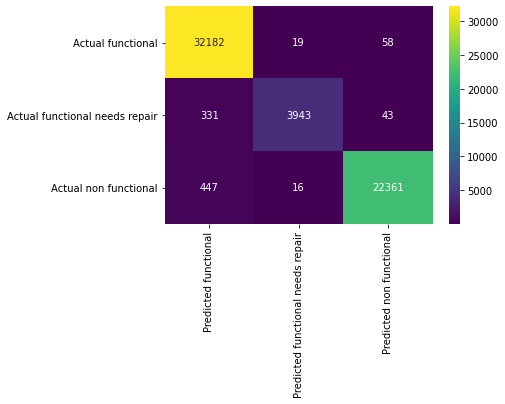

In [ ]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_train, y_pred);